## Task Overview

**Data**: Each entry is a fixed-size sequence of values, generated from 3 different distribution
 
 **Objective**: Predict the T next values given the previous S values of the seqeunce 

In [1]:
import pandas as pd
import numpy as np
import shutil
from datetime import datetime
import multiprocessing

import tensorflow as tf
from tensorflow import data
import tensorflow.contrib.rnn as rnn

import matplotlib.pyplot as plt

print(tf.__version__)

/Users/khalidsalama/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


1.4.0


In [2]:
MODEL_NAME = 'seq-model-02'

SEQUENCE_LENGTH = 20
INPUT_SEQUENCE_LENGTH = 16
OUTPUT_SEQUENCE_LENGTH = SEQUENCE_LENGTH - INPUT_SEQUENCE_LENGTH

TRAIN_DATA_SIZE = 1200 # sequences (entries)
TEST_DATA_SIZE = 300

TRAIN_DATA_FILE = 'data/seq02.train.csv'
TEST_DATA_FILE = 'data/seq02.test.csv'

RESUME_TRAINING = True
MULTI_THREADING = True

SKIP_DATA_GENERATION = True

## Generate Sequence Data

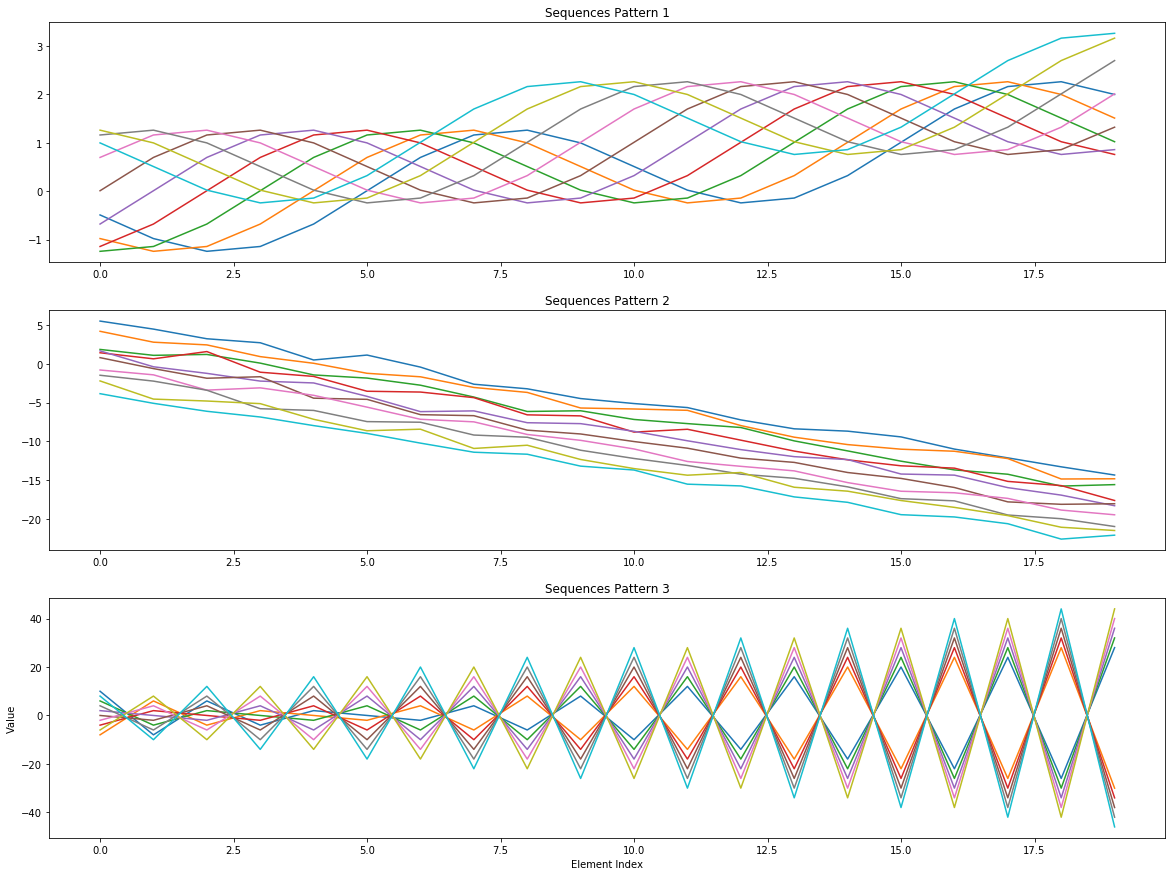

In [3]:
NOISE_RANGE = 0.01
TREND = 10.
OSCILIATION = 5.
np.random.seed = 19831006

def create_sequence1(start_value):

    x =  np.array(range(start_value, start_value+SEQUENCE_LENGTH))
    noise = np.random.normal(0, NOISE_RANGE, SEQUENCE_LENGTH)
    y = np.sin(np.pi * x / OSCILIATION) + (x / TREND + NOISE_RANGE)
    return y


def create_sequence2(start_value):

    x =  np.array(range(start_value, start_value+SEQUENCE_LENGTH))
    noise = np.random.normal(0, NOISE_RANGE+0.5, SEQUENCE_LENGTH)
    y = -x + noise
    return y


def create_sequence3(start_value):

    x =  np.array(range(start_value, start_value+SEQUENCE_LENGTH))
    y = []
    
    for x_i in x:
        y_i = 0
        if x_i % 2 == 0:
            y_i = x_i * 2
        else:
            y_i =  - x_i * 2
        y += [y_i]
        
    return y

plt.close('all')
plt.figure(figsize=(20, 15))

plt.subplot(3,1,1)
plt.title("Sequences Pattern 1")

for i in range(-5, 5):
    
    x = range(SEQUENCE_LENGTH)
    y = create_sequence1(i)
    plt.plot(x,y)
    
    
plt.subplot(3,1,2)
plt.title("Sequences Pattern 2")

for i in range(-5, 5):
    
    x = range(SEQUENCE_LENGTH)
    y = create_sequence2(i)
    plt.plot(x,y)
    

plt.subplot(3,1,3)
plt.title("Sequences Pattern 3")

for i in range(-5, 5):
    
    x = range(SEQUENCE_LENGTH)
    y = create_sequence3(i)
    plt.plot(x,y)


plt.xlabel("Element Index")
plt.ylabel("Value")
plt.show()

In [4]:
patterns = 3
start = int(-1*TRAIN_DATA_SIZE/(2*patterns))
end = int(TRAIN_DATA_SIZE/(2*patterns))

def to_csv():
    
    with open(TRAIN_DATA_FILE, 'w') as train_file_writer:
        with open(TEST_DATA_FILE, 'w') as test_file_writer:
            
            for line_index in range(start, end):
                
                sequence1 = create_sequence1(line_index)
                csv_line1 = ",".join(map(str, sequence1))
                
                sequence2 = create_sequence2(line_index)
                csv_line2 = ",".join(map(str, sequence2))
                
                sequence3 = create_sequence3(line_index)
                csv_line3 = ",".join(map(str, sequence3))
                
                if line_index  % 6 == 0:
                    test_file_writer.write(csv_line1 + '\n')
                    test_file_writer.write(csv_line2 + '\n')
                    test_file_writer.write(csv_line3 + '\n')
                else:
                    train_file_writer.write(csv_line1 + '\n')
                    train_file_writer.write(csv_line2 + '\n')
                    train_file_writer.write(csv_line3 + '\n')
                    
if not SKIP_DATA_GENERATION:               
    to_csv()

In [5]:
df1 = pd.read_csv(TRAIN_DATA_FILE,header=None)
df2 = pd.read_csv(TEST_DATA_FILE,header=None)
print(len(df1))
print(len(df2))

999
201


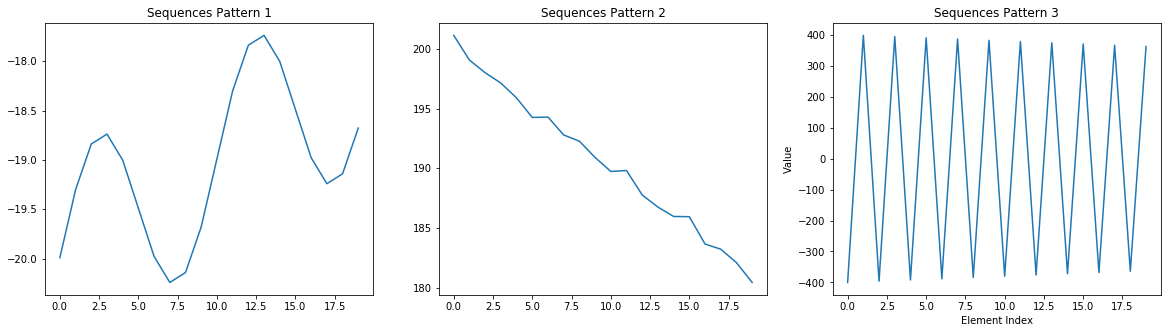

In [29]:
plt.close('all')
plt.figure(figsize=(20, 5))

plt.subplot(1,3,1)
plt.title("Sequences Pattern 1")
x = range(SEQUENCE_LENGTH)
y = df1.iloc[0,:]
plt.plot(x,y)

plt.subplot(1,3,2)
plt.title("Sequences Pattern 2")
x = range(SEQUENCE_LENGTH)
y = df1.iloc[1,:]
plt.plot(x,y)

plt.subplot(1,3,3)
plt.title("Sequences Pattern 3")
x = range(SEQUENCE_LENGTH)
y = df1.iloc[2,:]
plt.plot(x,y)
    
plt.xlabel("Element Index")
plt.ylabel("Value")
plt.show()    

## 1. Define Dataset Metadata

In [7]:
DEFAULTS = [[0.0] for i in range(0, SEQUENCE_LENGTH)]
VALUES_FEATURE_NAME = 'values'

## 2. Define Data Input Function

In [8]:
def parse_csv_row(csv_row):
    
    # sequence is a list of tensors
    sequence = tf.decode_csv(tf.expand_dims(csv_row, -1), record_defaults=DEFAULTS)  
    
    input_sequence = sequence[ :INPUT_SEQUENCE_LENGTH]  # input elements in the sequence
    output_sequence = sequence[INPUT_SEQUENCE_LENGTH: ] # output elements in the sequence
    
    input_sequence_tensor = tf.concat(input_sequence, axis=1)
    output_sequence_tensor = tf.concat(output_sequence, axis=1)
    
    return {VALUES_FEATURE_NAME: input_sequence_tensor}, output_sequence_tensor

In [9]:
def csv_input_fn(files_name_pattern, mode=tf.estimator.ModeKeys.EVAL, 
                 skip_header_lines=0, 
                 num_epochs=1, 
                 batch_size=20):
    
    shuffle = True if mode == tf.estimator.ModeKeys.TRAIN else False
    
    num_threads = multiprocessing.cpu_count() if MULTI_THREADING else 1
    
    print("")
    print("* data input_fn:")
    print("================")
    print("Input file(s): {}".format(files_name_pattern))
    print("Batch size: {}".format(batch_size))
    print("Epoch Count: {}".format(num_epochs))
    print("Mode: {}".format(mode))
    print("Shuffle: {}".format(shuffle))
    print("================")
    print("")
    
    file_names = tf.matching_files(files_name_pattern)

    dataset = data.TextLineDataset(filenames=file_names)
    dataset = dataset.skip(skip_header_lines)
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=2 * batch_size + 1)

    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda csv_row: parse_csv_row(csv_row), 
                          num_parallel_calls=num_threads)
    
    #dataset = dataset.batch(batch_size) #??? very long time
    dataset = dataset.repeat(num_epochs)
    iterator = dataset.make_one_shot_iterator()
    
    features, target = iterator.get_next()
    return features, target

In [10]:
features, target = csv_input_fn(files_name_pattern="")
print("Features in CSV: {}".format(features))
print("Target in CSV: {}".format(target))


* data input_fn:
Input file(s): 
Batch size: 20
Epoch Count: 1
Mode: eval
Shuffle: False

Features in CSV: {'values': <tf.Tensor 'IteratorGetNext:0' shape=(?, 16) dtype=float32>}
Target in CSV: Tensor("IteratorGetNext:1", shape=(?, 4), dtype=float32)


## 3. Define RNN Model Function

In [11]:
def rnn_model_fn(features, labels, mode, params):
    
    # 0. Reformat input shape to become a sequence
    inputs = tf.split(features[VALUES_FEATURE_NAME], INPUT_SEQUENCE_LENGTH, 1)
    
    # 1. configure the RNN
    lstm_cell = rnn.BasicLSTMCell(
        num_units=params.hidden_units, 
        forget_bias=params.forget_bias,
        activation=tf.nn.tanh
    )

    
    outputs, _ = rnn.static_rnn(cell=lstm_cell, 
                                inputs=inputs, 
                                dtype=tf.float32)
    
    # slice to keep only the last cell of the RNN
    outputs = outputs[-1]
    
    predictions = tf.layers.dense(inputs=outputs,
                                  units=OUTPUT_SEQUENCE_LENGTH,
                                  activation=None)
    
    predict_output = {'values': predictions}
    
    if mode == tf.estimator.ModeKeys.PREDICT:

        export_outputs = {
                'predictions': tf.estimator.export.PredictOutput(predict_output)
            }

        return tf.estimator.EstimatorSpec(
                mode=mode,
                predictions=predict_output,
                export_outputs=export_outputs)


    # Calculate loss using mean squared error
    loss = tf.losses.mean_squared_error(labels, predictions)

    # Create Optimiser
    optimizer = tf.train.AdamOptimizer(learning_rate=params.learning_rate)

    # Create training operation
    train_op = optimizer.minimize(
        loss=loss, global_step=tf.train.get_global_step())

    # Calculate root mean squared error as additional eval metric
    eval_metric_ops = {
        "rmse": tf.metrics.root_mean_squared_error(labels, predictions),
        "mae": tf.metrics.mean_absolute_error(labels, predictions)
    }

    # Provide an estimator spec for `ModeKeys.EVAL` and `ModeKeys.TRAIN` modes.
    estimator_spec = tf.estimator.EstimatorSpec(mode=mode,
                                                loss=loss,
                                                train_op=train_op,
                                                eval_metric_ops=eval_metric_ops)

    return estimator_spec


def create_estimator(run_config, hparams):
    estimator = tf.estimator.Estimator(model_fn=rnn_model_fn, 
                                  params=hparams, 
                                  config=run_config)
    
    print("")
    print("Estimator Type: {}".format(type(estimator)))
    print("")

    return estimator

## 5. Run Experiment

### a. Set HParam and RunConfig

In [12]:
NUM_EPOCHS = 10000
BATCH_SIZE = 200
EVAL_AFTER_SEC = 15
TOTAL_STEPS = (TRAIN_DATA_SIZE/BATCH_SIZE)*NUM_EPOCHS

hparams  = tf.contrib.training.HParams(
    num_epochs = NUM_EPOCHS,
    batch_size = BATCH_SIZE,
    hidden_units=30,
    forget_bias=1.0,
    learning_rate=0.01,
    max_steps = TOTAL_STEPS
)

model_dir = 'trained_models/{}'.format(MODEL_NAME)

run_config = tf.estimator.RunConfig(
    tf_random_seed=19830610,
    model_dir=model_dir
)

print(hparams)
print("Model Directory:", run_config.model_dir)
print("")
print("Dataset Size:", TRAIN_DATA_SIZE)
print("Batch Size:", BATCH_SIZE)
print("Steps per Epoch:",TRAIN_DATA_SIZE/BATCH_SIZE)
print("Total Steps:", TOTAL_STEPS)
print("That is 1 evaluation step after each",EVAL_AFTER_SEC," training seconds")

[('batch_size', 200), ('forget_bias', 1.0), ('hidden_units', 30), ('learning_rate', 0.01), ('max_steps', 6000.0), ('num_epochs', 1000)]
Model Directory: trained_models/seq-model-02

Dataset Size: 1200
Batch Size: 200
Steps per Epoch: 6.0
Total Steps: 6000.0
That is 1 evaluation step after each 15  training seconds


###  b. Define Serving Function

In [13]:
def csv_serving_input_fn():
    
    SERVING_DEFAULTS =  [[0.0] for i in range(0, INPUT_SEQUENCE_LENGTH)]

    rows_string_tensor = tf.placeholder(dtype=tf.string,
                                         shape=[None],
                                         name='csv_rows')
    
    receiver_tensor = {'csv_rows': rows_string_tensor}

    row_columns = tf.expand_dims(rows_string_tensor, -1)
    columns = tf.decode_csv(row_columns, record_defaults=SERVING_DEFAULTS)
    input_sequence_tensor = tf.concat(columns, axis=1)
    features = {VALUES_FEATURE_NAME: input_sequence_tensor}

    return tf.estimator.export.ServingInputReceiver(
        features, receiver_tensor)

### c. Define TrainSpec and EvaluSpec

In [14]:
train_spec = tf.estimator.TrainSpec(
    input_fn = lambda: csv_input_fn(
        TRAIN_DATA_FILE,
        mode = tf.estimator.ModeKeys.TRAIN,
        num_epochs=hparams.num_epochs,
        batch_size=hparams.batch_size
    ),
    max_steps=hparams.max_steps,
    hooks=None
)

eval_spec = tf.estimator.EvalSpec(
    input_fn = lambda: csv_input_fn(
        TRAIN_DATA_FILE,
        mode=tf.estimator.ModeKeys.EVAL,
        num_epochs=1,
        batch_size=hparams.batch_size,
            
    ),
    exporters=[tf.estimator.LatestExporter(
        name="forecast",  # the name of the folder in which the model will be exported to under export
        serving_input_receiver_fn=csv_serving_input_fn,
        exports_to_keep=1,
        as_text=True)],
    #throttle_secs = EVAL_AFTER_SEC,
    steps=None
)

### d. Run the experiment via tf.estimator.train_and_evaluate()

In [15]:
if not RESUME_TRAINING:
    print("Removing previous artifacts...")
    shutil.rmtree(model_dir, ignore_errors=True)
else:
    print("Resuming training...") 

    
tf.logging.set_verbosity(tf.logging.INFO)

time_start = datetime.utcnow() 
print("Experiment started at {}".format(time_start.strftime("%H:%M:%S")))
print(".......................................") 

estimator = create_estimator(run_config, hparams)

tf.estimator.train_and_evaluate(
    estimator=estimator,
    train_spec=train_spec, 
    eval_spec=eval_spec
)

time_end = datetime.utcnow() 
print(".......................................")
print("Experiment finished at {}".format(time_end.strftime("%H:%M:%S")))
print("")
time_elapsed = time_end - time_start
print("Experiment elapsed time: {} seconds".format(time_elapsed.total_seconds()))
    

Resuming training...
Experiment started at 15:07:38
.......................................
INFO:tensorflow:Using config: {'_model_dir': 'trained_models/seq-model-02', '_tf_random_seed': 19830610, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x127a4dd30>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

Estimator Type: <class 'tensorflow.python.estimator.estimator.Estimator'>

INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 600 secs (eval_spec.throttle_secs) or training is finished.

* data input_fn:
Input file(s): data/seq02.train.csv
Batch size: 

INFO:tensorflow:Saving checkpoints for 6000 into trained_models/seq-model-02/model.ckpt.
INFO:tensorflow:Loss for final step: 518.165.

* data input_fn:
Input file(s): data/seq02.train.csv
Batch size: 200
Epoch Count: 1
Mode: eval
Shuffle: False

INFO:tensorflow:Starting evaluation at 2017-11-28-15:09:18
INFO:tensorflow:Restoring parameters from trained_models/seq-model-02/model.ckpt-6000
INFO:tensorflow:Finished evaluation at 2017-11-28-15:09:19
INFO:tensorflow:Saving dict for global step 6000: global_step = 6000, loss = 258.812, mae = 7.25441, rmse = 16.0617
INFO:tensorflow:Restoring parameters from trained_models/seq-model-02/model.ckpt-6000
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b"trained_models/seq-model-02/export/forecast/temp-b'1511881759'/saved_model.pbtxt"
.......................................
Experiment finished at 15:09:20

Experiment elapsed time: 102.361697 seconds


In [16]:
train_input_fn = lambda: csv_input_fn(files_name_pattern= TRAIN_DATA_FILE, 
                                      mode= tf.estimator.ModeKeys.EVAL,
                                      batch_size= TRAIN_DATA_SIZE)

test_input_fn = lambda: csv_input_fn(files_name_pattern= TEST_DATA_FILE, 
                                      mode= tf.estimator.ModeKeys.EVAL,
                                      batch_size= TEST_DATA_SIZE)

estimator = create_estimator(run_config, hparams)

train_results = estimator.evaluate(input_fn=train_input_fn, steps=1)
train_rmse = str(train_results["rmse"])
print()
print("######################################################################################")
print("# Train RMSE: {} - {}".format(train_rmse, train_results))
print("######################################################################################")

test_results = estimator.evaluate(input_fn=test_input_fn, steps=1)
test_rmse = str(test_results["rmse"])
print()
print("######################################################################################")
print("# Test RMSE: {} - {}".format(test_rmse, test_results))
print("######################################################################################")

INFO:tensorflow:Using config: {'_model_dir': 'trained_models/seq-model-02', '_tf_random_seed': 19830610, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x127a4dd30>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

Estimator Type: <class 'tensorflow.python.estimator.estimator.Estimator'>


* data input_fn:
Input file(s): data/seq02.train.csv
Batch size: 1200
Epoch Count: 1
Mode: eval
Shuffle: False

INFO:tensorflow:Starting evaluation at 2017-11-28-15:09:22
INFO:tensorflow:Restoring parameters from trained_models/seq-model-02/model.ckpt-6000
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-11-28-15:09:23
INFO:tensorflow:Savin

## 6. Prediction

In [21]:
import itertools

LEN = 999

predict_input_fn = lambda: csv_input_fn(files_name_pattern= TRAIN_DATA_FILE, 
                                      mode= tf.estimator.ModeKeys.PREDICT,
                                      batch_size=TRAIN_DATA_SIZE)

predictions = list(itertools.islice(estimator.predict(input_fn=predict_input_fn),LEN))
prediction_outputs = list(map(lambda item: list(item["values"]),predictions[:3]))
print()
print("Predicted Values: {}".format(prediction_outputs))


* data input_fn:
Input file(s): data/seq02.train.csv
Batch size: 1200
Epoch Count: 1
Mode: infer
Shuffle: False

INFO:tensorflow:Restoring parameters from trained_models/seq-model-02/model.ckpt-6000

Predicted Values: [[-18.662397, -18.139839, -19.124474, -18.701056], [153.32339, 163.25891, 152.05132, 161.01106], [-337.42422, 334.7121, -338.7612, 335.4234]]


In [34]:

forecasted_values = list(map(lambda item: list(item["values"])[0],predictions))
forecasted_seq1 = []
forecasted_seq2 = []
forecasted_seq3 = []

i = 0

while i < LEN:
    forecasted_seq1 += [forecasted_values[i]]
    forecasted_seq2 += [forecasted_values[i+1]]
    forecasted_seq3 += [forecasted_values[i+2]]
    i += 3
    
# print(len(forecasted_seq1))
# print(len(forecasted_seq2))
# print(len(forecasted_seq3))

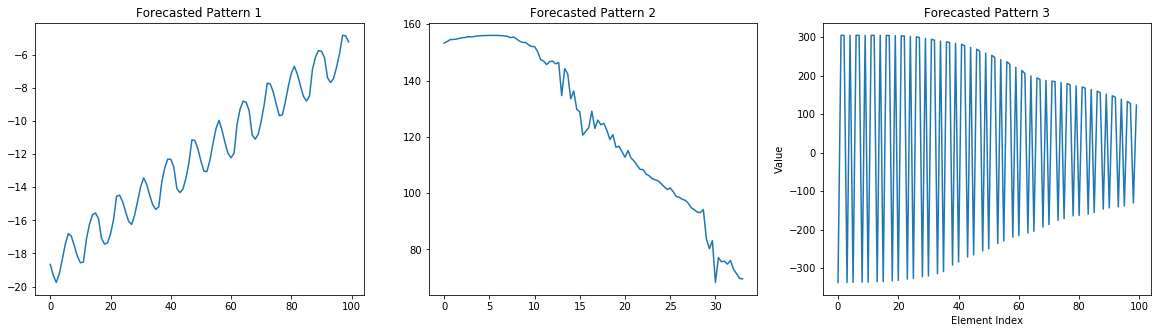

In [42]:
l = 100
x = np.array(range(0, l ))

plt.close('all')
plt.figure(figsize=(20, 5))

plt.subplot(1,3,1)
plt.title("Forecasted Pattern 1")
y = forecasted_seq1[:l ]
plt.plot(x,y)

plt.subplot(1,3,2)
plt.title("Forecasted Pattern 2")
y = forecasted_seq2[:l ]
plt.plot(x/3,y)

plt.subplot(1,3,3)
plt.title("Forecasted Pattern 3")
y = forecasted_seq3[: l]
plt.plot(x,y)
    
plt.xlabel("Element Index")
plt.ylabel("Value")
plt.show() 

## 7. Serving the Exported Model

In [20]:
import os

export_dir = model_dir +"/export/forecast"

saved_model_dir = export_dir + "/" + os.listdir(path=export_dir)[-1] 

print(saved_model_dir)

predictor_fn = tf.contrib.predictor.from_saved_model(
    export_dir = saved_model_dir,
    signature_def_key="predictions"
)

output = predictor_fn({'csv_rows': ['1,2,3,4,5,6,7,8,9,10,9,8,7,6,5,4']})
print(output)

trained_models/seq-model-02/export/forecast/1511881759
INFO:tensorflow:Restoring parameters from b'trained_models/seq-model-02/export/forecast/1511881759/variables/variables'
{'values': array([[ 3.92981315,  3.12676525,  3.53820276,  3.05192375]], dtype=float32)}
